# Neural Ordinary Differential Equations

The algorithm above describes backpropagation of gradients for the ODE initial value problem with subsequent observations. This algorithm lies in the heart of Neural ODEs.

In case there are many observations along the trajectory, one computes the adjoint augmented ODE dynamics for subsequent observations, adjusting the backpropagated gradients with direct gradients at observation times, as shown above on *figure 1*.

# Implementation 

The code below is an implementation of the **Neural ODE**. I did it solely for better understanding of what's going on. However it is very close to what is actually implemented in authors' [repository](https://github.com/rtqichen/torchdiffeq). This notebook collects all the code that's necessary for understanding in one place and is slightly more commented.

In [33]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
from google.colab import files

Implement any ordinary differential equation initial value solver. For the sake of simplicity it'll be Euler's ODE initial value solver, however any explicit or implicit method will do.

In [ ]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters.  In order to not have to specify them by hand for every new architecture, we will use **torch.autograd.grad** method.

In [ ]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below incapsulates forward and backward passes of *Neural ODE*. We have to separate it from main ***torch.nn.Module*** because custom backward function can't be implemented inside Module, but can be implemented inside ***torch.autograd.Function***. So this is just a little workaround.

This function underlies the whole Neural ODE method.

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrap ode adjoint function in **nn.Module** for convenience.

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Application

## _Learning true dynamics function (proof of concept)_

As a proof-of-concept we will now test if Neural ODE can indeed restore true dynamics function using sampled data.

To test this we will specify an ODE, evolve it and sample points on its trajectory, and then restore it.

First, we'll test a simple linear ODE. Dynamics is given with a matrix.

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

Trained function here is also a simple matrix.

The trained function here is also a simple matrix.

![leaning gif](https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/linear_learning.gif?raw=1)

Next, slighty more sophisticated dynamics (no gif as its learning process is not so satisfying :)).  
Trained function here is MLP with one hidden layer.
![complicated result](https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/comp_result.png?raw=1)

In [ ]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Dynamics is simply given with a matrix.

In [ ]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Initial random linear dynamics function to be optimized

In [ ]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

More sophisticated dynamics for creating trajectories

In [ ]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Dynamics function to be optimized is MLP

In [ ]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy()

In [34]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [38]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"{i}.png")
            clear_output(wait=True)

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

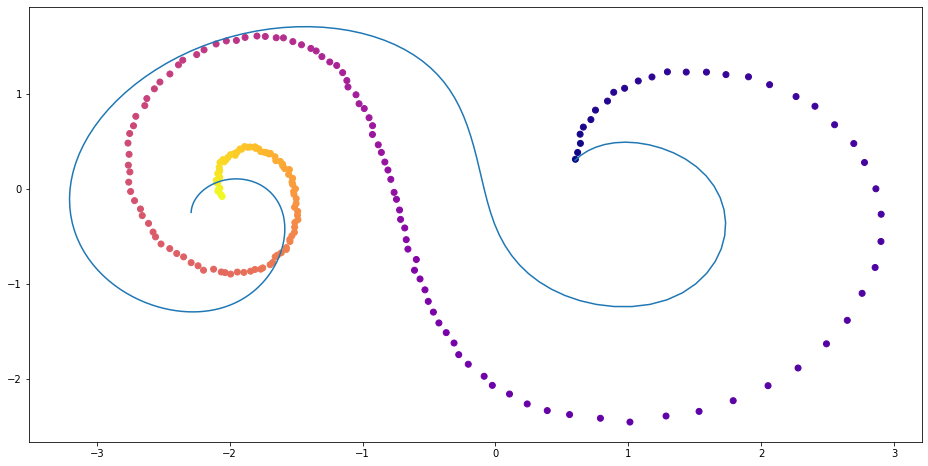

In [39]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

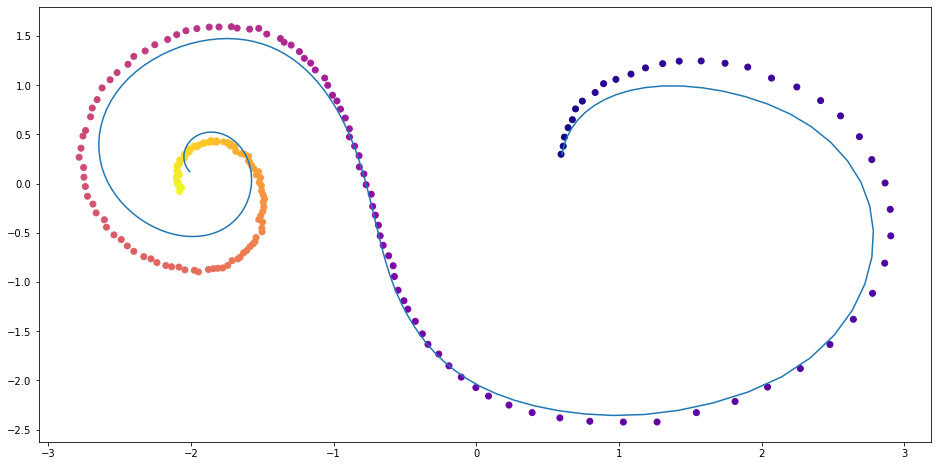

In [40]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

As one can see, Neural ODEs are pretty successful in approximating dynamics. Now let's check if they can be used in a slightly more complicated (MNIST) task.

## Neural ODE inspired by ResNets 

In residual networks hidden state changes according to the formula
$$
h_{t+1} = h_{t} + f(h_{t}, \theta_{t})
$$

where $t \in \{0...T\}$ is residual block number and $f$ is a function learned by layers inside the block.

If one takes a limit of an infinite number of residual blocks with smaller steps one gets continuous dynamics of hidden units to be an ordinary differential equation just as we had above.

$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$

Starting from the input layer $h(0)$, one can deﬁne the output layer $h(T)$ to be the solution to this ODE initial value problem at some time T.

Now one can treat $\theta$ as parameters shared among all infinitesimally small residual blocks.

### Testing Neural ODE architecture on MNIST

In this section we test the ability of Neural ODE's to be used as a component in more conventional architectures. 
In particular, we will use Neural ODE in place of residual blocks in MNIST classifier.

<img src="https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/mnist_example.png?raw=1" width=400></img>

In [ ]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw





Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [31]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test Accuracy: 99.140%
Training Epoch 1...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Train loss: 0.02992
Testing...



Test Accuracy: 98.830%
Training Epoch 2...



Train loss: 0.02313
Testing...



Test Accuracy: 99.260%
Training Epoch 3...



Train loss: 0.01936
Testing...



Test Accuracy: 99.290%
Training Epoch 4...



Train loss: 0.01750
Testing...



Test Accuracy: 98.820%
Training Epoch 5...



Train loss: 0.01528
Testing...



Test Accuracy: 99.290%


<Figure size 648x360 with 0 Axes>

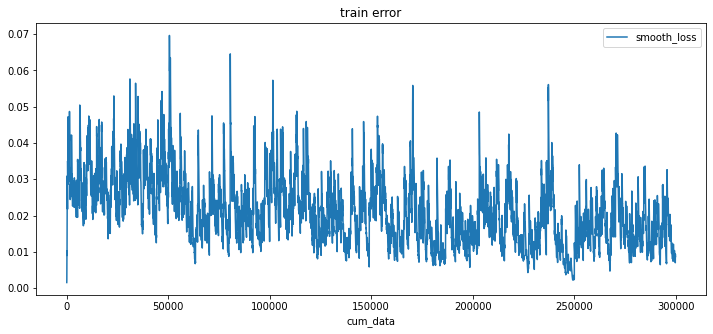

In [32]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

```
Testing...
100% 79/79 [00:01<00:00, 45.69it/s]
Test Accuracy: 9.740%

Training Epoch 1...
100% 1875/1875 [01:15<00:00, 24.69it/s]
Train loss: 0.20137
Testing...
100% 79/79 [00:01<00:00, 46.64it/s]
Test Accuracy: 98.680%

Training Epoch 2...
100% 1875/1875 [01:17<00:00, 24.32it/s]
Train loss: 0.05059
Testing...
100% 79/79 [00:01<00:00, 46.11it/s]
Test Accuracy: 97.760%

Training Epoch 3...
100% 1875/1875 [01:16<00:00, 24.63it/s]
Train loss: 0.03808
Testing...
100% 79/79 [00:01<00:00, 45.65it/s]
Test Accuracy: 99.000%

Training Epoch 4...
100% 1875/1875 [01:17<00:00, 24.28it/s]
Train loss: 0.02894
Testing...
100% 79/79 [00:01<00:00, 45.42it/s]
Test Accuracy: 99.130%

Training Epoch 5...
100% 1875/1875 [01:16<00:00, 24.67it/s]
Train loss: 0.02424
Testing...
100% 79/79 [00:01<00:00, 45.89it/s]
Test Accuracy: 99.170%
```

![train error](https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/train_error.png?raw=1)

After a very rough training procedure of only 5 epochs and 6 minutes of training the model already has test error of less than 1%. Which shows that Neural ODE architecture fits very good as a component in more conventional nets.

In their paper, authors also compare this classifier to simple 1-layer MLP, to ResNet with alike architecture, and to same ODE architecture, but in which gradients propagated directly through ODESolve (without adjoint gradient method) (RK-Net).
!["Methods comparison"](https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/methods_compare.png?raw=1)
<div align="center">Figure from original paper</div>

According to them, 1-layer MLP with roughly the same amount of parameters as Neural ODE-Net has much higher test error, ResNet with roughly the same error has much more parameters, and RK-Net with direct backpropagation through ODESolver has slightly higher error and linearly growing memory usage.

In their paper, authors use implicit Runge-Kutta solver with adaptive step size instead of simple Euler's method. They also examine some ODE-Net characteristics.

!["Node attrs"](https://github.com/piyush007978/Neural_ODE/blob/master/neural-ode-master/assets/ode_solver_attrs.png?raw=1)

<div align="center">ODE-Net characteristics (NFE Forward - number of function evaluations during forward pass)</div>
<div align="center">Figure from original paper</div>

- (a) Changing tolerable Numerical Error varies the number of steps per forward pass evaluation.
- (b) Time spent by the forward call is proportional to the number of function evaluations.
- (c) Number of backward evaluations is roughly half the number of forward evaluations, this suggests that adjoint method is more computationally efficient than direct backpropagation through ODESolver.
- (d) As ODE-Net becomes more and more trained, it demands more and more evaluations, presumably adapting to the increasing complexity of the model.

This concludes my little investigation of **Neural ODEs**. Hope you found it useful!

# Useful links

   - [Original paper](https://arxiv.org/abs/1806.07366)
   - [Authors' PyTorch implementation](https://github.com/rtqichen/torchdiffeq)
   - [Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)